# GoogleNet
- Cifar10
- Notebooks@Azure
- Python 3.8.5
- Inception块中的层使用torch中的Sequential实现类似容器加入BatchNormlization并激活Relu函数
- 在第一、二个卷积层后添加加入BatchNormlization并激活了Relu函数
- 使用随机梯度下降（SGD）优化器、余弦退火学习率调度器、权重衰减
- 损失函数为交叉熵损失函数
- Cuda加速
- 使用pytorch、torchvision内置方法加载数据集
- 数据增强，数据预处理
- 使用sklearn.metrics模块获得测试准确率和F1得分
- 使用自定义的train()函数
- 为什么要重写Train():
    d2l中内置的train_ch13已经能满足需求但是没法再堆叠打印出F1得分并且trainloss在过程中一直是趋近于0不符合实际我觉得存在bug并且使用自定义的Train()可以更自由的调节lr，在需要查看整个过程中的数据在GoogleNet中可以查看所有的数据做出更精细化的调整
----

#### 数据增强
- 从输入图像中随机裁剪一个大小为 32x32 的部分，并进行 4 像素的填充。
- 以 0.5 的概率随机水平翻转图像。
- 通过减去每个通道的均值并除以标准差值，对张量图像进行归一化。提供的均值和标准差值对应于 CIFAR-10 数据集的 RGB 通道。

### 模型调整说明
- 将第一个卷积核修改为3x3/1有助于更好地捕捉图像中的局部特征。
- 去除b2中的一个1x1卷积核有助于减少模型的复杂度，从而避免过拟合。
- 去除maxpool1和maxpool2有助于保留更多的图像信息，从而提高分类精度。


In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import accuracy_score, f1_score

class Inception(nn.Module):
    def __init__(self, in_planes, n1x1, n3x3red, n3x3, n5x5red, n5x5, pool_planes):
        super(Inception, self).__init__()
        # 1x1 conv 
        self.b1 = nn.Sequential(
            nn.Conv2d(in_planes, n1x1, kernel_size=1),
            nn.BatchNorm2d(n1x1),
            nn.ReLU(True),
        )
        
        # 1x1 conv -> 3x3 conv 
        self.b2 = nn.Sequential(
            nn.Conv2d(in_planes, n3x3red, kernel_size=1),
            nn.BatchNorm2d(n3x3red),
            nn.ReLU(True),
            nn.Conv2d(n3x3red, n3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(n3x3),
            nn.ReLU(True),
        )

        # 1x1 conv -> 5x5 conv 
        self.b3 = nn.Sequential(
            nn.Conv2d(in_planes, n5x5red, kernel_size=1),
            nn.BatchNorm2d(n5x5red),
            nn.ReLU(True),
            nn.Conv2d(n5x5red, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(True),
            nn.Conv2d(n5x5, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(True),
        )

        # 3x3 pool -> 1x1 conv
        self.b4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.Conv2d(in_planes, pool_planes, kernel_size=1),
            nn.BatchNorm2d(pool_planes),
            nn.ReLU(True),
        )

    def forward(self, x):
        y1 = self.b1(x)
        y2 = self.b2(x)
        y3 = self.b3(x)
        y4 = self.b4(x)
        return torch.cat([y1,y2,y3,y4], 1)

In [3]:
b1 = nn.Sequential(
                   nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
                   nn.BatchNorm2d(64),
                   nn.ReLU(inplace=True),)

In [4]:
b2 = nn.Sequential(
                   nn.Conv2d(64, 64, kernel_size=1),
                   nn.BatchNorm2d(64),
                   nn.ReLU(inplace=True),
                   nn.Conv2d(64, 192, kernel_size=3, padding=1),
                   nn.BatchNorm2d(192),
                   nn.ReLU(inplace=True),)

In [5]:

b3 = nn.Sequential(Inception(192, 64, 96, 128, 16, 32, 32),
                   Inception(256, 128, 128, 192, 32, 96, 64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [6]:
b4 = nn.Sequential(Inception(480, 192, 96, 208, 16, 48, 64),
                   Inception(512, 160, 112, 224, 24, 64, 64),
                   Inception(512, 128, 128, 256, 24, 64, 64),
                   Inception(512, 112, 144, 288, 32, 64, 64),
                   Inception(528, 256, 160, 320, 32, 128, 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [7]:
b5 = nn.Sequential(Inception(832, 256, 160, 320, 32, 128, 128),
                   Inception(832, 384, 192, 384, 48, 128, 128),
                   nn.AdaptiveAvgPool2d((1,1)),
                   nn.Flatten())

net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

In [8]:
transform_train=transforms.Compose([
    transforms.RandomCrop(32,padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
transform_test=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

In [9]:

batch_size = 128#批量大小
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)#加载CIFAR-10数据集，如果数据集不存在则会下载到./data文件夹下
train_iter = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)#对训练集进行数据预处理，transform_train是一个由多个数据处理操作组成的Pipeline
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)#对测试集进行数据预处理
test_iter = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)#

Files already downloaded and verified
Files already downloaded and verified


In [ ]:

if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))
net = net.to(device)

In [ ]:
num_epochs = 280

criterion = nn.CrossEntropyLoss()
optimizer=optim.SGD(net.parameters(),lr=0.001,momentum=0.9,weight_decay=5e-4)
scheduler=optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=num_epochs)
def train(net, trainloader, testloader, num_epochs, optimizer, criterion, device, scheduler):

    for epoch in range(num_epochs):
        net.train()  # 将模型设置为训练模式
        train_loss, train_acc, train_f1 = 0.0, 0.0, 0.0
        for i, (inputs, labels) in enumerate(trainloader, 0):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()

            optimizer.step()

            train_loss += loss.item()
            train_acc += accuracy_score(labels.cpu().numpy(), torch.argmax(outputs, axis=1).cpu().numpy())
            train_f1 += f1_score(labels.cpu().numpy(), torch.argmax(outputs, axis=1).cpu().numpy(), average='macro')
        scheduler.step()
        train_loss /= len(trainloader)
        train_acc /= len(trainloader)
        train_f1 /= len(trainloader)

        # 在测试集上验证模型性能
        net.eval()  # 将模型设置为评估模式
        test_loss, test_acc, test_f1 = 0.0, 0.0, 0.0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs)
                loss = criterion(outputs, labels)

                test_loss += loss.item()
                test_acc += accuracy_score(labels.cpu().numpy(), torch.argmax(outputs, axis=1).cpu().numpy())
                test_f1 += f1_score(labels.cpu().numpy(), torch.argmax(outputs, axis=1).cpu().numpy(), average='macro')

        test_loss /= len(testloader)
        test_acc /= len(testloader)
        test_f1 /= len(testloader)

        # 输出每个 epoch 的结果
        print('Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.4f}, Train F1: {:.4f}, Test Loss: {:.4f}, Test Acc: {:.4f}, Test F1: {:.4f}'
              .format(epoch+1, num_epochs, train_loss, train_acc, train_f1, test_loss, test_acc, test_f1))

train(net, train_iter, test_iter, num_epochs, optimizer, criterion, device, scheduler)

Epoch [1/280], Train Loss: 1.4732, Train Acc: 0.4567, Train F1: 0.4337, Test Loss: 1.1434, Test Acc: 0.5918, Test F1: 0.5834
Epoch [2/280], Train Loss: 0.9676, Train Acc: 0.6543, Train F1: 0.6442, Test Loss: 0.9510, Test Acc: 0.6699, Test F1: 0.6599
Epoch [3/280], Train Loss: 0.7426, Train Acc: 0.7407, Train F1: 0.7333, Test Loss: 0.8689, Test Acc: 0.7028, Test F1: 0.6980
Epoch [4/280], Train Loss: 0.6187, Train Acc: 0.7860, Train F1: 0.7793, Test Loss: 0.7129, Test Acc: 0.7575, Test F1: 0.7524
Epoch [5/280], Train Loss: 0.5380, Train Acc: 0.8147, Train F1: 0.8084, Test Loss: 0.6295, Test Acc: 0.7925, Test F1: 0.7785
Epoch [6/280], Train Loss: 0.4812, Train Acc: 0.8330, Train F1: 0.8267, Test Loss: 0.6105, Test Acc: 0.7959, Test F1: 0.7915
Epoch [7/280], Train Loss: 0.4249, Train Acc: 0.8533, Train F1: 0.8481, Test Loss: 0.6100, Test Acc: 0.8004, Test F1: 0.7875
Epoch [8/280], Train Loss: 0.3854, Train Acc: 0.8650, Train F1: 0.8605, Test Loss: 0.5267, Test Acc: 0.8257, Test F1: 0.8183


## 运行结果

- 结果使用输出值解析参数并绘制图表
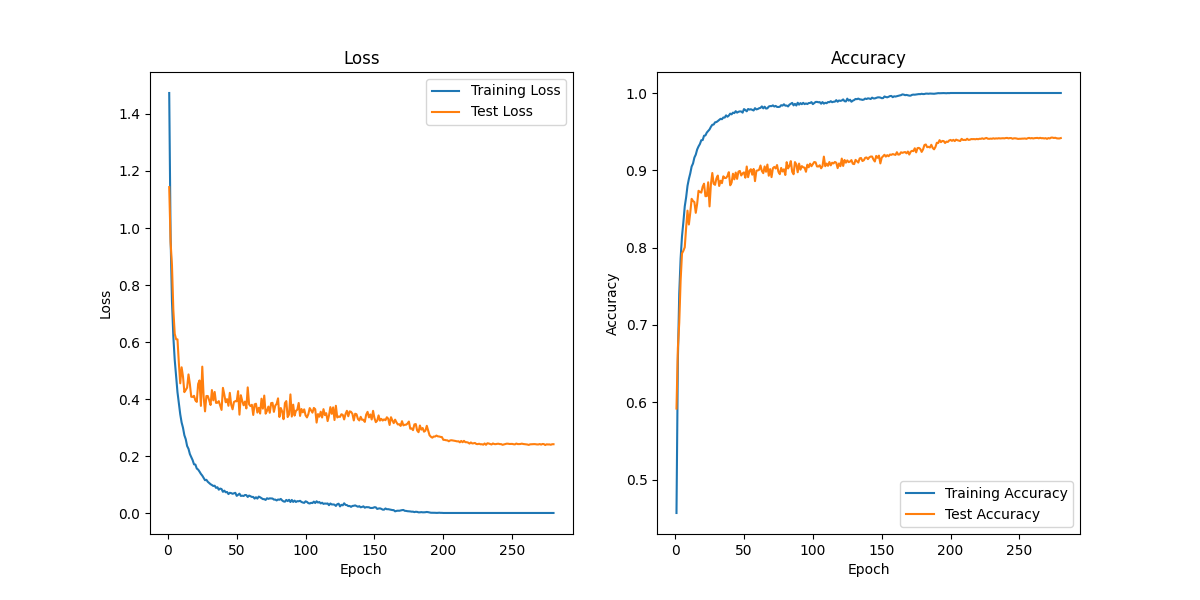
> Epoch [280/280], Train Loss: 0.0017, Train Acc: 1.0000, Train F1: 1.0000, Test Loss: 0.2426, Test Acc: 0.9417, Test F1: 0.9371
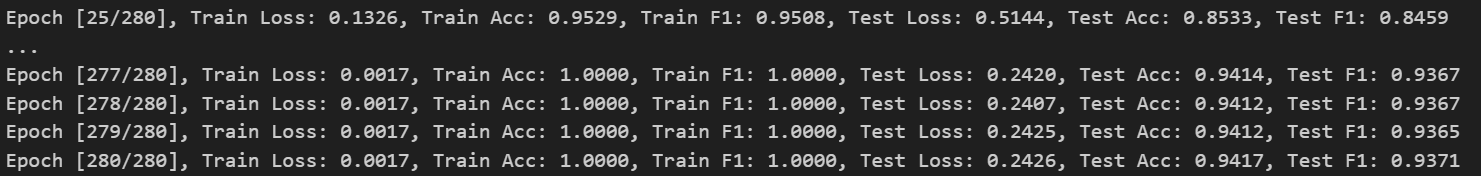
> 输出展示

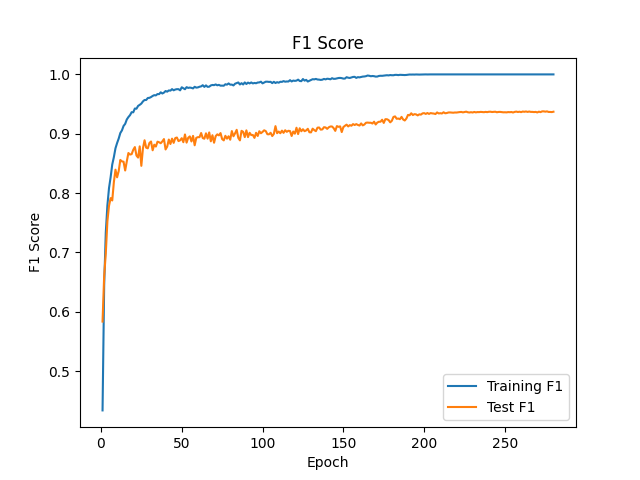
> F1 Score

绘制代码如下：
``` Python 
import matplotlib.pyplot as plt

# 从文本文件读取数据
with open('data.txt') as f:
    lines = f.readlines()

# 解析每一行数据并存储
epochs = []
train_loss = []
train_acc = []
train_f1 = []
test_loss = []
test_acc = []
test_f1 = []

for line in lines:
    parts = line.strip().split(',')
    epoch_str = parts[0].split(' ')[1].strip('[]')
    epoch = int(epoch_str.split('/')[0])
    epochs.append(epoch)
    train_loss.append(float(parts[1].split(': ')[1]))
    train_acc.append(float(parts[2].split(': ')[1]))
    train_f1.append(float(parts[3].split(': ')[1]))
    test_loss.append(float(parts[4].split(': ')[1]))
    test_acc.append(float(parts[5].split(': ')[1]))
    test_f1.append(float(parts[6].split(': ')[1]))

# 绘制损失和准确率曲线
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(epochs, train_loss, label='Training Loss')
ax1.plot(epochs, test_loss, label='Test Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(epochs, train_acc, label='Training Accuracy')
ax2.plot(epochs, test_acc, label='Test Accuracy')
ax2.set_title('Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()

# 绘制 F1 分数曲线
fig, ax = plt.subplots()

ax.plot(epochs, train_f1, label='Training F1')
ax.plot(epochs, test_f1, label='Test F1')
ax.set_title('F1 Score')
ax.set_xlabel('Epoch')
ax.set_ylabel('F1 Score')
ax.legend()

plt.show()

```


#### train( )函数
`train()`函数是一个基于PyTorch的函数，用于训练神经网络模型。它需要以下参数：
* `net`： 要训练的神经网络模型。
* `trainloader`： 训练数据加载器。
* `testloader`： 测试数据加载器。
* `num_epochs`： 训练的历时数。
* `optimizer`： 训练时使用的优化器。
* `criterion`： 训练中使用的损失函数。
* `device`： 训练模型的设备（CPU或GPU）。
* `scheduler`： 学习率调度器（可选）。

函数首先调用 `d2l`中`Animator`类创建一个对象来绘制图像跟踪训练的进展。然后，进入一个指定的轮数的循环。在每轮中，该函数做以下工作：

1. 将模型设置为训练模式。
2. 遍历训练数据加载器，对每批数据进行前向传递和后向传递。
3. 使用优化器更新模型参数。
4. 计算训练损失和准确性。
5. 在测试数据上评估模型，并计算测试损失和准确性以及F1得分(用于评估模型训练的效果)
6. 将计算所得的试损失和准确率、F1得分打印输出

若使用了一个学习率调度器，`train`函数将在每个历时结束时更新学习率。


#### 参数说明
参数说明如下：

- Learning Rate（学习率）：0.01。

- Batch Size（批大小）：128。

- Epochs（训练轮数）：280。

- Weight Decay（权重衰减）：5e-4。

- Momentum（动量）：0.9。动量系数为 0.9，当前的梯度更新方向受到 90% 的动量影响。